<a href="https://colab.research.google.com/github/KevinTheRainmaker/Speech_Emotion_Classifier/blob/main/SpeechEmotionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np

import os
import sys

# to analyze audio
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [51]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drive_path = '/content/drive/MyDrive/data/emotional_speech'

Mounted at /content/drive


In [52]:
# paths
crema = os.path.join(drive_path, "CREMA-D")
savee = os.path.join(drive_path, "SAVEE")
ravdess = os.path.join(drive_path, "RAVDESS")
tess = os.path.join(drive_path, "TESS")

## Data Preperation

### 1. CREMA Dataframe

In [53]:
crema_directory_list = os.listdir(crema)

In [54]:
file_emotion = []
file_path = []
for file in crema_directory_list:
  # storing file paths
  file_path.append(crema + '/' + file)
  # storing file emotions
  part=file.split('_')
  if part[2] == 'SAD':
      file_emotion.append('sad')
  elif part[2] == 'ANG':
      file_emotion.append('angry')
  elif part[2] == 'DIS':
      file_emotion.append('disgust')
  elif part[2] == 'FEA':
      file_emotion.append('fear')
  elif part[2] == 'HAP':
      file_emotion.append('happy')
  elif part[2] == 'NEU':
      file_emotion.append('neutral')
  else:
      file_emotion.append('Unknown')

In [55]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df.shape)
emotion_df.head()

(7442, 1)


,Emotions
0,angry
1,angry
2,disgust
3,sad
4,disgust


In [56]:
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
print(crema_df.shape)
crema_df.head()

(7442, 2)


,Emotions,Path
0,angry,/content/drive/MyDrive/data/emotional_speech/C...
1,angry,/content/drive/MyDrive/data/emotional_speech/C...
2,disgust,/content/drive/MyDrive/data/emotional_speech/C...
3,sad,/content/drive/MyDrive/data/emotional_speech/C...
4,disgust,/content/drive/MyDrive/data/emotional_speech/C...


### 2. SAVEE Dataset

In [57]:
savee_directory_list = os.listdir(savee)

In [58]:
file_emotion = []
file_path = []

for file in savee_directory_list:
  file_path.append(savee + '/' + file)
  part = file.split('_')[1]
  ele = part[:-6]
  if ele=='a':
      file_emotion.append('angry')
  elif ele=='d':
      file_emotion.append('disgust')
  elif ele=='f':
      file_emotion.append('fear')
  elif ele=='h':
      file_emotion.append('happy')
  elif ele=='n':
      file_emotion.append('neutral')
  elif ele=='sa':
      file_emotion.append('sad')
  else:
      file_emotion.append('surprise')

In [59]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df.shape)
emotion_df.head()

(480, 1)


,Emotions
0,angry
1,angry
2,angry
3,angry
4,angry


In [60]:
path_df = pd.DataFrame(file_path, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis=1)
print(savee_df.shape)
savee_df.head()

(480, 2)


,Emotions,Path
0,angry,/content/drive/MyDrive/data/emotional_speech/S...
1,angry,/content/drive/MyDrive/data/emotional_speech/S...
2,angry,/content/drive/MyDrive/data/emotional_speech/S...
3,angry,/content/drive/MyDrive/data/emotional_speech/S...
4,angry,/content/drive/MyDrive/data/emotional_speech/S...


### 3. RAVDESS Dataframe

**Filename identifiers**

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

- Vocal channel (01 = speech, 02 = song).

- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

- Repetition (01 = 1st repetition, 02 = 2nd repetition).

- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [61]:
ravdess_directory_list = os.listdir(ravdess)

In [62]:
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
  actor = os.listdir(ravdess + '/' + dir)
  for file in actor:
    part = file.split('.')[0]
    part = part.split('-')
    # print(part[2])
    file_emotion.append(int(part[2]))
    file_path.append(ravdess + '/' + dir + '/' + file)

In [63]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df.shape)
emotion_df.head()

(1440, 1)


,Emotions
0,2
1,2
2,2
3,1
4,2


In [64]:
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.head()

,Emotions,Path
0,2,/content/drive/MyDrive/data/emotional_speech/R...
1,2,/content/drive/MyDrive/data/emotional_speech/R...
2,2,/content/drive/MyDrive/data/emotional_speech/R...
3,1,/content/drive/MyDrive/data/emotional_speech/R...
4,2,/content/drive/MyDrive/data/emotional_speech/R...


In [65]:
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(ravdess_df.shape)
ravdess_df.head()

(1440, 2)


,Emotions,Path
0,calm,/content/drive/MyDrive/data/emotional_speech/R...
1,calm,/content/drive/MyDrive/data/emotional_speech/R...
2,calm,/content/drive/MyDrive/data/emotional_speech/R...
3,neutral,/content/drive/MyDrive/data/emotional_speech/R...
4,calm,/content/drive/MyDrive/data/emotional_speech/R...


### 4. TESS Dataset

In [66]:
tess_directory_list = os.listdir(tess)

In [67]:
file_emotion = []
file_path = []

for dir in tess_directory_list:
  directories = os.listdir(tess + '/' + dir)
  # print(directories)
  for file in directories:
    part = file.split('.')[0]
    part = part.split('_')[2]
    if part=='ps':
      file_emotion.append('surprise')
    else:
      file_emotion.append(part)
    file_path.append(tess + '/' + dir + '/' + file)

In [68]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df.shape)
emotion_df.head()

(2800, 1)


,Emotions
0,happy
1,happy
2,happy
3,happy
4,happy


In [69]:
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

,Emotions,Path
0,happy,/content/drive/MyDrive/data/emotional_speech/T...
1,happy,/content/drive/MyDrive/data/emotional_speech/T...
2,happy,/content/drive/MyDrive/data/emotional_speech/T...
3,happy,/content/drive/MyDrive/data/emotional_speech/T...
4,happy,/content/drive/MyDrive/data/emotional_speech/T...


In [70]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis = 0)
data_path.to_csv(os.path.join(drive_path, "data_path.csv"),index=False)
print(data_path.shape)
data_path.head()

(12162, 2)


,Emotions,Path
0,calm,/content/drive/MyDrive/data/emotional_speech/R...
1,calm,/content/drive/MyDrive/data/emotional_speech/R...
2,calm,/content/drive/MyDrive/data/emotional_speech/R...
3,neutral,/content/drive/MyDrive/data/emotional_speech/R...
4,calm,/content/drive/MyDrive/data/emotional_speech/R...


## Data Visualization

In [71]:
data_path = pd.read_csv(os.path.join(drive_path, "data_path.csv"))
data_path.tail()

,Emotions,Path
12157,neutral,/content/drive/MyDrive/data/emotional_speech/S...
12158,neutral,/content/drive/MyDrive/data/emotional_speech/S...
12159,surprise,/content/drive/MyDrive/data/emotional_speech/S...
12160,surprise,/content/drive/MyDrive/data/emotional_speech/S...
12161,sad,/content/drive/MyDrive/data/emotional_speech/S...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


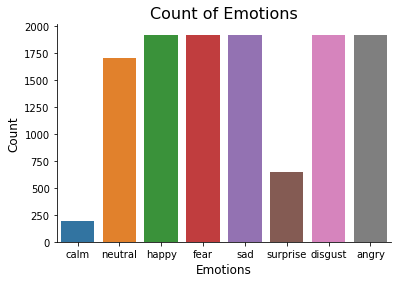

In [72]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [74]:
# waveplot: loudness of the audio
def create_waveplot(data, sr, e):
  plt.figure(figsize=(10, 3))
  plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
  librosa.display.waveplot(data, sr=sr)
  plt.show()

# spectrogram: frequencies changing with respect to time for the audio
def create_spectrogram(data, sr, e):
  # stft function converts the data into short term fourier transform
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12, 3))
  plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
  #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
  plt.colorbar()

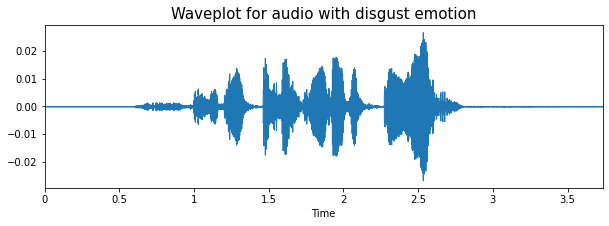

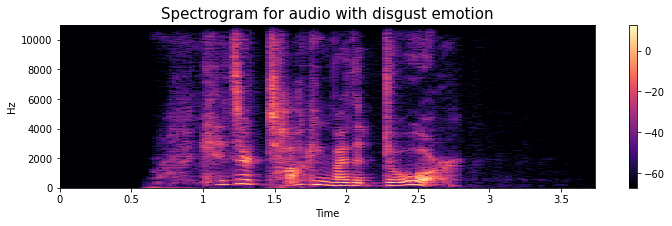

In [75]:
emotion = 'disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[5]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [94]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

def shift(data):
  data_roll = np.roll(data, int(len(data) * 0.5)) # roll_rate: 0.5
  # shift_range = int(np.random.uniform(low=-7, high = 7)*1000)
  # return np.roll(data, shift_range)
  return data_roll

def pitch(data, sampling_rate, pitch_factor=0.8):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def minus(data, sampling_rate):
  temp_numpy = (-1)*data
  return data

In [106]:
# testing augmentation
path = np.array(data_path.Path)[0]
data, sample_rate = librosa.load(path)

In [107]:
path

'/content/drive/MyDrive/data/emotional_speech/RAVDESS/Actor_20/03-01-02-02-02-01-20.wav'

In [108]:
data

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [109]:
sample_rate

22050

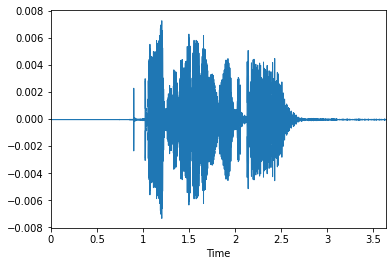

In [96]:
# normal
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(data, rate=sample_rate)

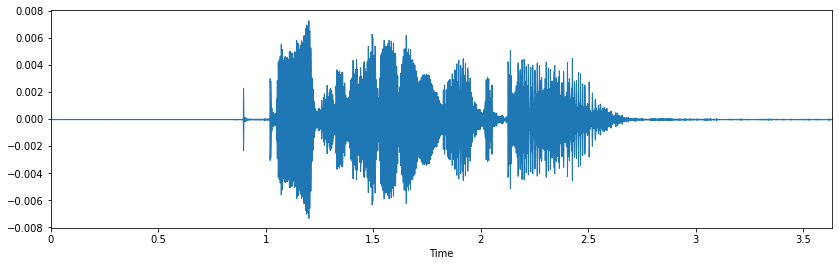

In [97]:
# noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

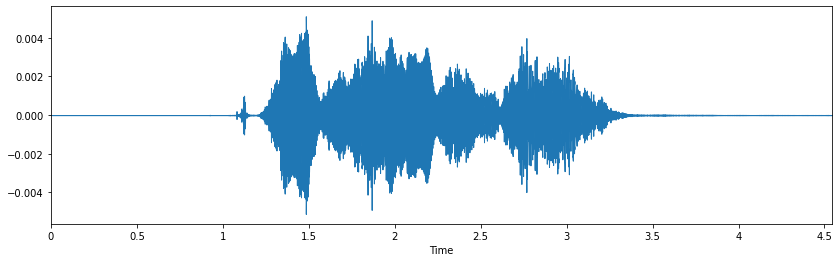

In [98]:
# stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

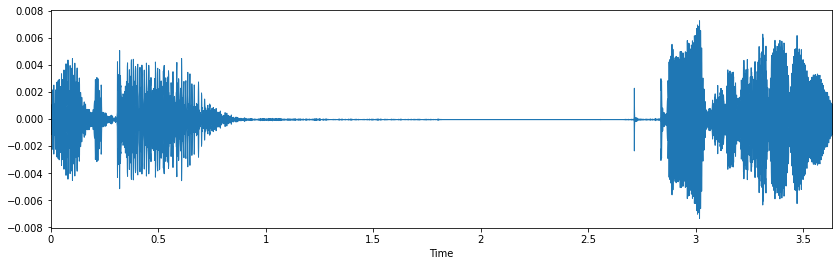

In [99]:
# shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

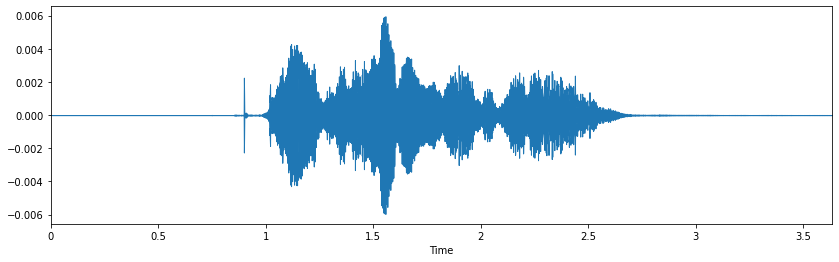

In [100]:
# pitching
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

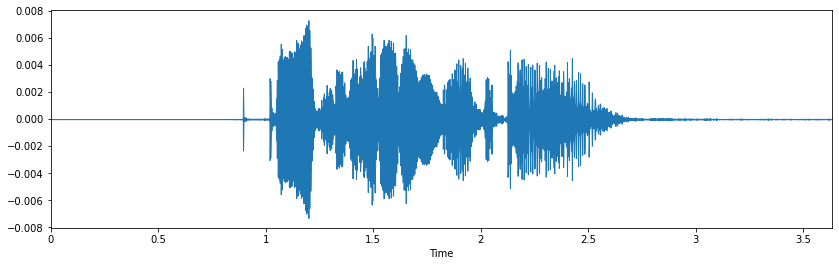

In [101]:
# minus
x = minus(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram

Ref: https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

In [102]:
def extract_features(data):
  # ZCR
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr)) # stacking horizontally

  # Chroma_stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))

  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # Root Mean Square Value
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))

  # MelSpectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  
  return result

In [115]:
def get_features(path):
  # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
  
  # without augmentation
  res1 = extract_features(data)
  result = np.array(res1)
  
  # data with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2)) # stacking vertically
  
  # data with stretching
  stretch_data = stretch(data)
  res3 = extract_features(stretch_data)
  result = np.vstack((result, res3))

  # data with shifting
  shift_data = shift(data)
  res4 = extract_features(shift_data)
  result = np.vstack((result, res4))

  # data with pitching
  pitch_data = pitch(data, sample_rate)
  res5 = extract_features(pitch_data)
  result = np.vstack((result, res5))

  # data to be minused
  minus_data = minus(data, sample_rate)
  res6 = extract_features(minus_data)
  result = np.vstack((result, res6))

  # data with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res7 = extract_features(data_stretch_pitch)
  result = np.vstack((result, res7))
  
  return result

In [116]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
  feature = get_features(path)
  for ele in feature:
      X.append(ele)
      # appending emotion 7 times as we have made 7 augmentation techniques on each audio file.
      Y.append(emotion)

3192it [50:25,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
12162it [2:54:21,  1.16it/s]


(36486, 36486, (12162,))

In [117]:
len(X), len(Y), data_path.Path.shape

(85134, 85134, (12162,))

In [118]:
Features = pd.DataFrame(X)
Features['labels'] = Y
path = '/content/drive/MyDrive/data/emotional_speech'
Features.to_csv(os.path.join(path, "features_re.csv"), index=False)
print(Features.shape)
Features.head()

(85134, 163)


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.273356,0.552561,0.558262,0.607316,0.630895,0.570546,0.558530,0.614101,0.701532,0.765123,...,0.000014,0.000008,0.000010,0.000010,0.000013,0.000013,0.000017,0.000005,3.603246e-07,calm
1,0.296283,0.645673,0.657232,0.689755,0.744166,0.718371,0.650243,0.651948,0.727284,0.803353,...,0.000015,0.000009,0.000011,0.000011,0.000015,0.000014,0.000019,0.000006,1.547819e-06,calm
2,0.197320,0.554422,0.571120,0.589119,0.649638,0.594392,0.563031,0.593001,0.678094,0.772646,...,0.000006,0.000004,0.000005,0.000004,0.000006,0.000005,0.000008,0.000002,1.690188e-07,calm
3,0.276498,0.574476,0.580046,0.616233,0.651218,0.586976,0.565408,0.609900,0.695196,0.787729,...,0.000014,0.000008,0.000010,0.000010,0.000013,0.000013,0.000017,0.000005,3.609483e-07,calm
4,0.199056,0.607824,0.567340,0.572106,0.577168,0.585157,0.550781,0.545020,0.586650,0.695404,...,0.000004,0.000004,0.000005,0.000003,0.000006,0.000005,0.000005,0.000001,1.488648e-07,calm


## Normalize & Split

In [119]:
# Features = pd.read_csv(os.path.join(drive_path, "features.csv"))
Features = pd.read_csv(os.path.join(drive_path, "features_re.csv"))
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.273356,0.552561,0.558262,0.607316,0.630895,0.570546,0.558530,0.614101,0.701532,0.765123,...,0.000014,0.000008,0.000010,0.000010,0.000013,0.000013,0.000017,0.000005,3.603246e-07,calm
1,0.296283,0.645673,0.657232,0.689755,0.744166,0.718371,0.650243,0.651948,0.727284,0.803353,...,0.000015,0.000009,0.000011,0.000011,0.000015,0.000014,0.000019,0.000006,1.547819e-06,calm
2,0.197320,0.554422,0.571120,0.589119,0.649638,0.594392,0.563031,0.593001,0.678094,0.772646,...,0.000006,0.000004,0.000005,0.000004,0.000006,0.000005,0.000008,0.000002,1.690188e-07,calm
3,0.276498,0.574476,0.580046,0.616233,0.651218,0.586976,0.565408,0.609900,0.695196,0.787729,...,0.000014,0.000008,0.000010,0.000010,0.000013,0.000013,0.000017,0.000005,3.609483e-07,calm
4,0.199056,0.607824,0.567340,0.572106,0.577168,0.585157,0.550781,0.545020,0.586650,0.695404,...,0.000004,0.000004,0.000005,0.000003,0.000006,0.000005,0.000005,0.000001,1.488648e-07,calm


In [120]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [121]:
# since it is multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [122]:
# split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25 ,random_state=0, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(51080, 162) (51080, 8)
(17027, 162) (17027, 8)
(17027, 162) (17027, 8)


In [123]:
# scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

In [124]:
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(51080, 162, 1) (51080, 8)
(17027, 162, 1) (17027, 8)
(17027, 162, 1) (17027, 8)


## Modeling

In [145]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [146]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 21, 128)         

In [147]:
# checkpoint_cb = ModelCheckpoint('best-model.h5')
# checkpoint_cb = ModelCheckpoint('best-model-es.h5')
checkpoint_cb = ModelCheckpoint('best-model-100.h5')
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

# 재학습 돌릴 것

In [148]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(x_val, y_val), 
                    callbacks=[rlrp, checkpoint_cb])#, early_stopping_cb])

Epoch 1/100
799/799 [==============================] - 19s 22ms/step - loss: 1.5169 - accuracy: 0.3900 - val_loss: 1.2638 - val_accuracy: 0.4987 - lr: 0.0010
Epoch 2/100
799/799 [==============================] - 16s 20ms/step - loss: 1.2603 - accuracy: 0.4952 - val_loss: 1.1391 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 3/100
799/799 [==============================] - 16s 20ms/step - loss: 1.1806 - accuracy: 0.5285 - val_loss: 1.1261 - val_accuracy: 0.5508 - lr: 0.0010
Epoch 4/100
799/799 [==============================] - 16s 20ms/step - loss: 1.1334 - accuracy: 0.5479 - val_loss: 1.0663 - val_accuracy: 0.5674 - lr: 0.0010
Epoch 5/100
799/799 [==============================] - 16s 20ms/step - loss: 1.0993 - accuracy: 0.5634 - val_loss: 1.0366 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 6/100
799/799 [==============================] - 17s 21ms/step - loss: 1.0646 - accuracy: 0.5764 - val_loss: 1.0303 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 7/100
799/799 [==============================]

In [149]:
# Train the Model and save
# history = model.fit(x_train,
#                     y_train,
#                     batch_size=64,
#                     epochs=100, 
#                     validation_data=(x_test, y_test),
#                     callbacks=[checkpoint_cb, early_stopping_cb])

In [150]:
# Alarming when learning finished
# import time
# from google.colab.output import eval_js
# for i in range(5):
#   eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
#   time.sleep(2)

533/533 [==============================] - 4s 8ms/step - loss: 0.9273 - accuracy: 0.7869
Accuracy:  78.69266271591187 %


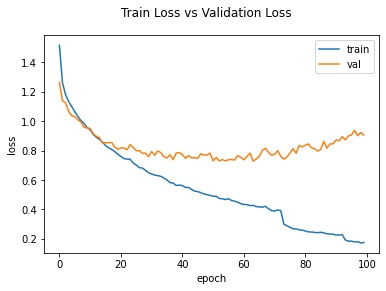

In [151]:
print("Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.suptitle("Train Loss vs Validation Loss")
plt.legend(['train', 'val'])
plt.show()

without early_stopping (50 epochs): acc 0.7399

without early_stopping (100 epochs): acc 0.7869

with early_stopping (18 epochs): acc 0.6559

In [152]:
  # Save Model HD5 to Drive
!cp best-model-100.h5 /content/drive/MyDrive/data/emotional_speech

In [153]:
model_loaded = tf.keras.models.load_model('best-model-100.h5')

In [154]:
# predicting on test data.
pred_test = model_loaded.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_encoded = encoder.inverse_transform(y_test)

In [155]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_encoded.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,happy
1,happy,happy
2,angry,angry
3,surprise,surprise
4,sad,sad
5,sad,sad
6,disgust,disgust
7,happy,happy
8,fear,fear
9,angry,angry


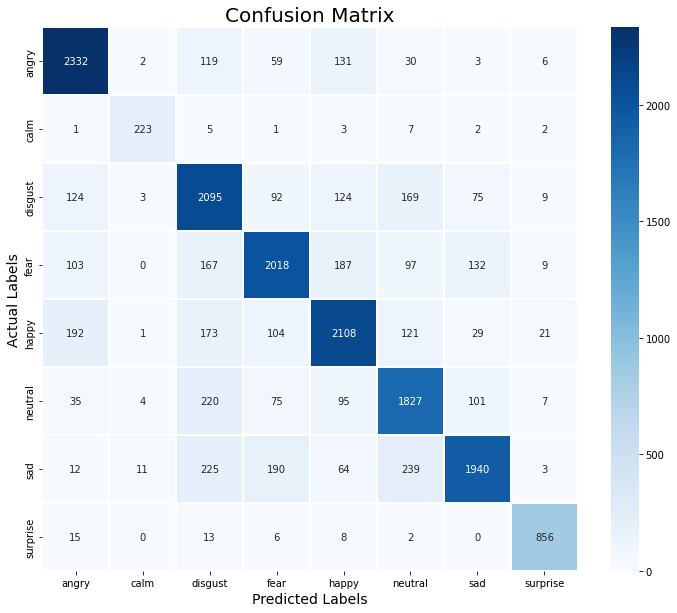

In [156]:
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [157]:
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

       angry       0.83      0.87      0.85      2682
        calm       0.91      0.91      0.91       244
     disgust       0.69      0.78      0.73      2691
        fear       0.79      0.74      0.77      2713
       happy       0.78      0.77      0.77      2749
     neutral       0.73      0.77      0.75      2364
         sad       0.85      0.72      0.78      2684
    surprise       0.94      0.95      0.94       900

    accuracy                           0.79     17027
   macro avg       0.82      0.81      0.81     17027
weighted avg       0.79      0.79      0.79     17027



### For one sample

In [158]:
x_test.shape

(17027, 162, 1)

In [161]:
data = x_test[1].reshape((1, x_test[1].shape[0], x_test[1].shape[1]))
data.shape

(1, 162, 1)

In [162]:
pred = model_loaded.predict(data)
result = encoder.inverse_transform(pred)
result

array([['happy']], dtype=object)